# Brief description of the problem and data 

## Problem
- Task: Predict if a tweet refers to a real disaster (1) or not (0).
- Type: Supervised binary NLP classification on short, noisy social media text.
- Evaluation Metric: F1 score.
- Submission Format: CSV with header: id, target.

## Data Files
- train.csv, test.csv.

## Columns
| Column  | Train | Test | Description |
|---------|-------|------|-------------|
| id      | yes     | yes    | Unique tweet identifier (integer) |
| text    | yes     | yes    | Raw tweet content (up to ~280 chars; hashtags, mentions, URLs, emojis) |
| keyword | yes     | yes    | Extracted keyword (string) |
| location| yes     | yes    | User-specified location (string; noisy, high cardinality) |
| target  | yes     | no    | Label: 1 = disaster-related, 0 = not |


## Output Requirement
- Predict target for every id in test.csv.
- Save as id,target with no extra columns.

## Metric Reminder
F1 = 2 * (precision * recall) / (precision + recall)

TP: predicted 1 and true 1  
FP: predicted 1 and true 0  
FN: predicted 0 and true 1

## EDA

In [2]:
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import re
import html

pd.set_option("display.max_colwidth", 160)
plt.style.use("seaborn-v0_8")
sns.set_context("talk")

DATA_DIR = Path("data")
assert (DATA_DIR / "train.csv").exists(), "Expected data/train.csv to exist"
assert (DATA_DIR / "test.csv").exists(), "Expected data/test.csv to exist"
assert (DATA_DIR / "sample_submission.csv").exists(), "Expected data/sample_submission.csv to exist"

In [3]:
import os, warnings, logging
os.environ["PYTHONWARNINGS"] = "ignore"      # env-level suppression
warnings.filterwarnings("ignore")            # blanket ignore
logging.getLogger().setLevel(logging.ERROR)  # silence most logged warnings

In [4]:
# Load data
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

print({
    "train_shape": train.shape,
    "test_shape": test.shape,
    "train_columns": train.columns.tolist(),
    "test_columns": test.columns.tolist(),
})

train.head(10)


{'train_shape': (7613, 5), 'test_shape': (3263, 4), 'train_columns': ['id', 'keyword', 'location', 'text', 'target'], 'test_columns': ['id', 'keyword', 'location', 'text']}


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [5]:
# Basic inspection
def missing_summary(df: pd.DataFrame):
    m = df.isna().sum()
    pct = (m / len(df) * 100).round(2)
    return pd.DataFrame({"missing": m, "%": pct}).sort_values("%", ascending=False)

print("Train dtypes:\n", train.dtypes.to_string())
print("\nTest dtypes:\n", test.dtypes.to_string())

print("\nMissing (train):")
display(missing_summary(train))
print("\nMissing (test):")
display(missing_summary(test))


Train dtypes:
 id           int64
keyword     object
location    object
text        object
target       int64

Test dtypes:
 id           int64
keyword     object
location    object
text        object

Missing (train):


,missing,%
location,2533,33.27
keyword,61,0.80
id,0,0.00
text,0,0.00
target,0,0.00



Missing (test):


,missing,%
location,1105,33.86
keyword,26,0.80
id,0,0.00
text,0,0.00


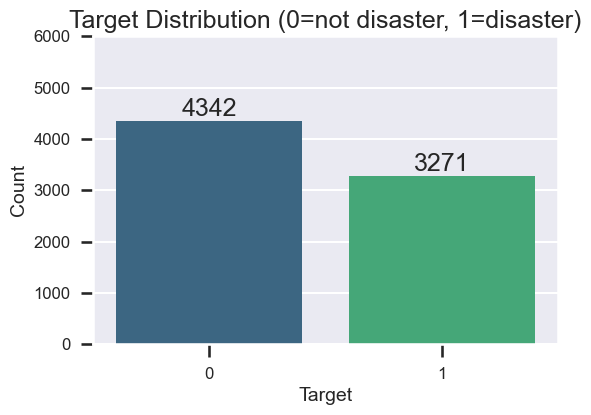

Positive class ratio: 0.430


In [6]:
# Target distribution visualization
fig, ax = plt.subplots(figsize=(6,4))
vc = train.target.value_counts().sort_index()
sns.barplot(x=vc.index, y=vc.values, ax=ax, palette="viridis")
ax.set_title("Target Distribution (0=not disaster, 1=disaster)", fontsize=18)
ax.set_xlabel("Target", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, 6000)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

plt.show()

positive_ratio = vc[1] / vc.sum()
print(f"Positive class ratio: {positive_ratio:.3f}")

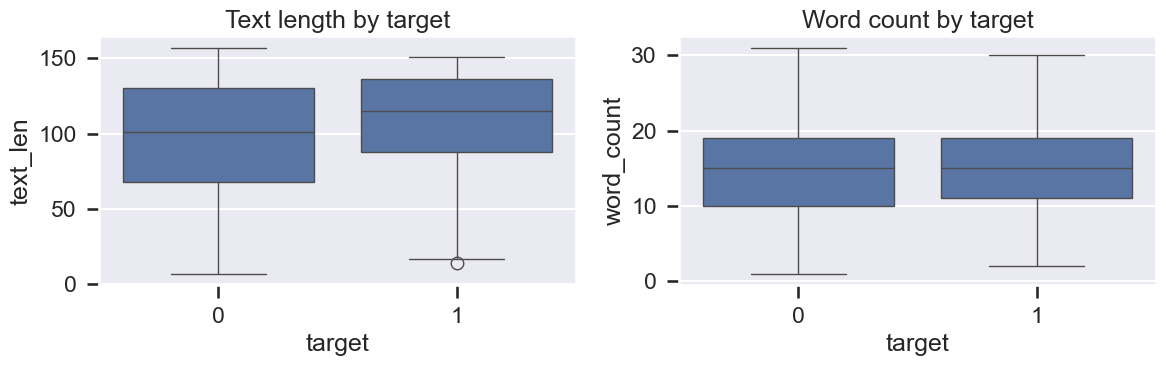

text_len               word_count              url_count               \
           mean median    std       mean median   std      mean median   std   
target                                                                         
0         95.71  101.0  35.89      14.70   15.0  6.16      0.51    0.0  0.67   
1        108.11  115.0  29.31      15.17   15.0  5.10      0.77    1.0  0.63   

       mention_count              hashtag_count               
                mean median   std          mean median   std  
target                                                        
0               0.42    0.0  0.77          0.39    0.0  1.00  
1               0.27    0.0  0.62          0.50    0.0  1.18

In [7]:
# Text feature exploration: lengths and social tokens
# Compute simple features from text
train["text_len"] = train["text"].astype(str).str.len()
train["word_count"] = train["text"].astype(str).str.split().map(len)
url_pat = r"https?://\S+|www\.\S+"
mention_pat = r"@\w+"
hashtag_pat = r"#\w+"
train["url_count"] = train["text"].fillna("").str.count(url_pat)
train["mention_count"] = train["text"].fillna("").str.count(mention_pat)
train["hashtag_count"] = train["text"].fillna("").str.count(hashtag_pat)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(data=train, x="target", y="text_len", ax=axes[0])

axes[0].set_title("Text length by target")
sns.boxplot(data=train, x="target", y="word_count", ax=axes[1])
axes[1].set_title("Word count by target")
plt.tight_layout(); plt.show()

# Summary stats by target for engineered features
summary = (train[["target", "text_len", "word_count", "url_count", "mention_count", "hashtag_count"]]
           .groupby("target").agg(["mean", "median", "std"]).round(2))
display(summary)

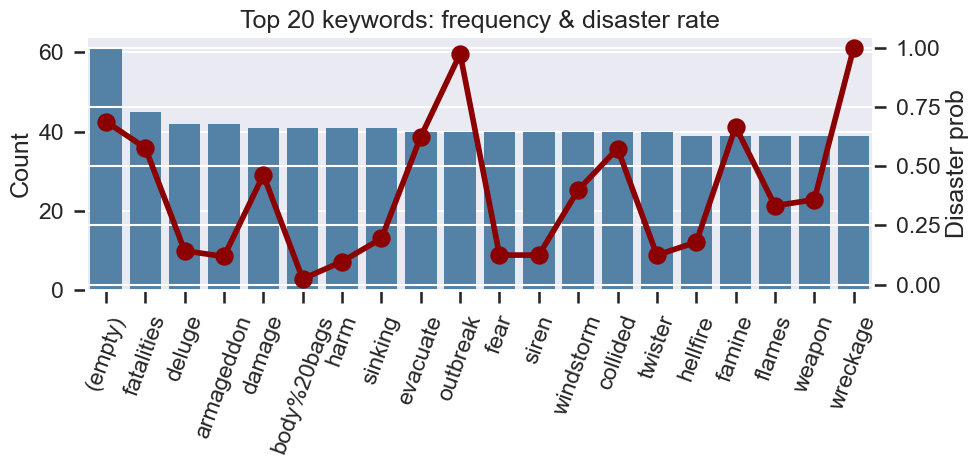

In [8]:
# Keyword frequency vs target
if 'keyword' in train.columns:
    top_keywords = (train['keyword'].fillna('')
                    .value_counts()
                    .head(20))
    kw_df = (train.assign(keyword=train['keyword'].fillna(''))
             .loc[train['keyword'].fillna('').isin(top_keywords.index)]
             .groupby('keyword')['target'].mean().reindex(top_keywords.index))
    fig, ax1 = plt.subplots(figsize=(10,5))
    x_adj = top_keywords.index.tolist()
    x_adj[0] = "(empty)"
    sns.barplot(x=x_adj, y=top_keywords.values, ax=ax1, color='steelblue')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=70)
    ax2 = ax1.twinx()
    sns.pointplot(x=x_adj, y=kw_df.values, ax=ax2, color='darkred')
    ax2.set_ylabel('Disaster prob')
    ax1.set_title('Top 20 keywords: frequency & disaster rate')
    plt.tight_layout(); plt.show()
else:
    print('No keyword column found.')



Location missing ratio: 33.27%; unique non-null locations: 3341


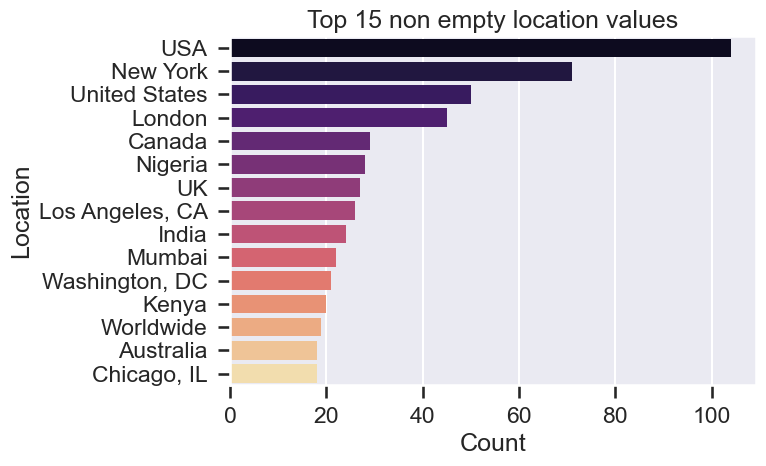

In [9]:
# Location & missingness analysis
loc_missing_ratio = train['location'].isna().mean()
unique_locations = train['location'].nunique(dropna=True)
print(f"Location missing ratio: {loc_missing_ratio:.2%}; unique non-null locations: {unique_locations}")

# Top 15 locations by frequency
loc_counts = train['location'].fillna('')[:]
loc_top = loc_counts.value_counts().head(16)
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(y=loc_top.index.tolist()[1:], x=loc_top.values.tolist()[1:], ax=ax, palette='magma')
ax.set_xlabel('Count')
ax.set_ylabel('Location')
ax.set_title('Top 15 non empty location values')
plt.tight_layout(); plt.show()

 

## EDA summary

### 1. Data 

- Train shape: (7613, 5)  
- Test shape: (3263, 4)

Columns and dtypes (train):
- id: int64
- keyword: object
- location: object
- text: object
- target: int64

Columns and dtypes (test):
- id: int64
- keyword: object
- location: object
- text: object


### 2. Missingness

Train missingness:
- location: 2,533 (33.27%)
- keyword: 61 (0.80%)
- id, text, target: 0

Test missingness:
- location: 1,105 (33.86%)
- keyword: 26 (0.80%)
- id, text: 0

Interpretation:
- Location is frequently absent and extremely heterogeneous when present (3,341 unique non-null entries). Heavy normalization or external geocoding would be required for reliable use.
- Keyword is largely present and likely curated; despite only 0.8% missingness, it covers a limited vocabulary and can be very predictive for a subset of samples.


### 3. Target distribution

- Counts: class 0 = 4,342; class 1 = 3,271  
- Positive class ratio: 0.430  
- Interpretation: Only mild imbalance. Use stratified splitting and consider class weights or threshold tuning if optimizing F1.


### 4. Text feature exploration

Simple features computed on `text`:
- text_len: character length
- word_count
- url_count: count of URLs (`https?://...` or `www.`)
- mention_count: count of `@\w+`
- hashtag_count: count of `#\w+`

#### 4.1 Length and tokenization


Groupwise summary (means):
- text_len: class 0 = 95.71, class 1 = 108.11  
- word_count: class 0 = 14.70, class 1 = 15.17

Interpretation:
- Disaster tweets are slightly longer and contain marginally more words. The effect size is small but consistent.

#### 4.2 Social tokens and media

Groupwise summary (means):
- url_count: class 0 = 0.51, class 1 = 0.77
- mention_count: class 0 = 0.42, class 1 = 0.27
- hashtag_count: class 0 = 0.39, class 1 = 0.50

Interpretation:
- Disaster tweets have more URLs and hashtags, suggesting linking to news or official info, and event tagging.
- Non-disaster tweets have more @mentions, suggesting conversational or social interactions rather than reporting.

Plan:
- Add binary flags for presence of URL/mention/hashtag in addition to raw counts; these often help linear models.


### 5. Keyword analysis

- The most frequent entry is the "empty" keyword (i.e., missing keyword), which has a mid-high disaster rate relative to others.
- Several keywords show near-deterministic behavior:
  - High disaster probability: "outbreak", "wreckage", "evacuate" (~0.7–1.0)
  - Low disaster probability: "body bags", "fear", "deluge" 
- Interpretation:
  - Keyword is a high-precision feature for a subset of samples; however, coverage is limited and vocabulary is moderate.
  - For modeling, consider:
    - One-hot or target-encoded keyword (with proper CV to avoid leakage).
    - Incorporating cleaned keywords into the main text (e.g., prepend "[kw=outbreak]" to `text_clean`) to let the text encoder exploit the signal.

Data quality note:
- Normalizing `keyword` (lowercasing, replacing hyphens and `%20`) consolidates variants such as "body%20bags" -> "body bags" and can slightly improve frequency estimates.


### 6. Location analysis

- Location is long-tailed and noisy.
- Top non-empty values include "USA", "New York", "United States", "London", etc., each with low counts relative to the full dataset.
- Despite normalization, heterogeneity remains significant; out-of-the-box modeling value is limited without robust geocoding, clustering, or mapping to standardized regions.

Plans:
- Country/city dictionary mapping or a geocoding service to canonical names and lat/lon.
- Coarse buckets (e.g., continent-level) to limit sparsity.
- A simple binary "has_location" feature may be as effective as raw strings given the weak correlation observed.


### 7. Feature Engineering (Details in model.ipynb)
Building a compact, leakage-safe feature set for the disaster tweets task by cleaning inputs, extracting lightweight numeric signals, and encoding categorical keywords with cross-validation.

#### 7.1 Normalize inputs
- text_clean: HTML unescape; replace URLs with "URL" and @mentions with "USER"; strip "#" from hashtags but keep the word; lowercase; collapse whitespace.
- keyword_clean: replace “%20” and “-” with spaces; lowercase; collapse whitespace.
- location_clean: lowercase; collapse whitespace.
- Social/media token signals (from raw text)
- Counts: url_count, mention_count, hashtag_count.
- Binary flags: has_url, has_mention, has_hashtag.
- Text length and tokenization
- text_len (chars) and word_count computed on cleaned text.
- text_kw: prepend a keyword tag like "[kw=outbreak] ..." to text_clean to expose keyword signal to text models (controlled by add_keyword_to_text).

#### 7.2 Presence flags
- has_keyword and has_location indicate whether the cleaned fields are non-empty.
- Leakage-safe target encoding for keyword
- keyword_te is computed via out-of-fold mean target encoding with StratifiedKFold:
- Train: each row gets a mean computed from other folds (no self-leakage).
- Test: mapped from full-training means; unseen keywords fall back to the global positive rate.
- Returns both the full mapping and global mean for inference.

#### 7.3 Organized outputs
- Preserves id (and target for train).
- Returns four objects: train_out, test_out, keyword_te_mapping, keyword_te_global_mean.
- Columns include cleaned fields, optional text_kw, numeric counts/flags, presence flags, and keyword_te.

#### 7.4 Result
- Cleaning stabilizes vocabulary for vectorizers/transformers.
- Simple social/media counts capture differences in usage patterns (URLs, mentions, hashtags).
- keyword_te compresses a sparse categorical into a powerful numeric feature while avoiding target leakage.
- text_kw lets text encoders directly exploit high-precision keyword signal.



# Model Architecture

## Task
- Binary classification: determine whether a tweet refers to a real disaster.
- Inputs (after feature engineering):
  - Sequence text: `text_kw` (preferred; else `text_clean`), already normalized and with `[kw=...]` tag.
  - Tabular features: `text_len`, `word_count`, `url_count`, `mention_count`, `hashtag_count`, `has_url`, `has_mention`, `has_hashtag`, `has_location`, `has_keyword`, and leakage-safe `keyword_te`.

## Design overview
- Hybrid model: a lightweight sequential encoder over tokens for text, fused with a small MLP over tabular signals, then a joint classifier.
  1. Text encoder
     - Token embedding: learnable embeddings (dim=128) for vocabulary built on training `text_kw` only.
     - BiLSTM (hidden=128, 1 layer, bidirectional): captures word order, negations, and local context. 
     - Sequence pooling: use the concatenation of last forward/backward hidden states (2 × 128) as the text representation. Dropout for regularization.
  2. Tabular branch (Feed-forward)
     - Inputs: standardized numeric features including `keyword_te`.
     - MLP: BatchNorm -> ReLU -> Dropout -> Linear stack (e.g., 64 hidden units). This learns non-linear interactions among counts/flags and the encoded keyword prior.
  3. Fusion and classification
     - Concatenate text and tabular representations -> Dropout -> Linear -> single logit.
     - Loss: Binary cross-entropy with logits (BCEWithLogitsLoss). Optionally use `pos_weight` to address mild imbalance.
     - Decision threshold: select on validation by maximizing F1.

## Regularization and training
- Dropout on both branches and fusion head; gradient clipping for stability.
- Early stopping on validation F1; learning rate 1e-3 with Adam.
- Standardize continuous tabular features using training-set statistics only (no leakage). Binary flags remain as 0/1.
- Optionally tune decision threshold on validation to maximize F1.


## Evaluation
- Primary metric: F1. Also monitor precision/recall to understand trade-offs.
- Report final validation metrics and generate a Kaggle-ready submission from test.

# Results and Analysis 

## Training Configuration
- Tokenization: whitespace over normalized text
- Hyperparameters:
  - max_len=50, min_freq=3, max_vocab_size=30000
  - embedding_dim=128, hidden_size=112
  - dropouts: txt=0.45, tab=0.40, fusion=0.45
  - batch_size=64, lr=8e-4, Adam (+ weight_decay=1e-4)
  - epochs=10, early_stopping_patience=2
- Validation threshold tuned per epoch to maximize F1; final threshold selected from best checkpoint.

## Validation Performance 
- Threshold: 0.480
- Overall:
  - F1: 0.7522
  - Precision: 0.7986
  - Recall: 0.7108
  - Accuracy: 0.7986

## Class-wise Metrics
- Class 0 (not disaster): P=0.7986, R=0.8648, F1=0.8304, support=651
- Class 1 (disaster):     P=0.7986, R=0.7108, F1=0.7522, support=491

## Training Dynamics
- F1 by epoch (peak at epoch 4):
  - Epoch 1: F1=0.7168
  - Epoch 2: F1=0.7378
  - Epoch 3: F1=0.7445
  - Epoch 4: F1=0.7522 (best)
  - Epoch 5: F1=0.7513
  - Epoch 6: F1=0.7393
- Early stopping triggered at epoch 6, best checkpoint retained from epoch 4.

## Summary
- Hybrid BiLSTM + MLP achieves a strong, balanced F1 with high precision and solid recall.
- Vocabulary pruning (min_freq=3), shorter max_len, and moderate dropout reduced overfitting vs the baseline.
- Leakage-safe `keyword_te` contributes a robust prior; combined with social-token features, it complements the text encoder.


# Conclusion

## Overview
- Final model: Hybrid BiLSTM (text) + MLP (tabular).
- Inputs: Cleaned `text_kw` plus tabular features (social token counts/flags, presence flags, and leakage-safe `keyword_te`).
- Best validation performance: F1 = 0.7522 (Precision = 0.7986, Recall = 0.7108, Acc = 0.7986) at threshold 0.48.
- Improvement over baseline: F1 0.7446 → 0.7522 after targeted regularization and vocabulary/length pruning.

## What helped
- Hybrid architecture: Combining a sequence encoder with tabular priors (especially `keyword_te`) consistently outperformed text-only.
- Leakage-safe target encoding: Out-of-fold `keyword_te` provided a stable prior without leaking labels.
- Injecting keyword into text: The `[kw=...]` prefix let the sequence model condition on the curated keyword within the text context.
- Regularization and model right-sizing:
  - Increased dropout (text/fusion/tab) and L2 weight decay curbed overfitting.
  - Reducing hidden size from 128 → 112 balanced capacity.
  - Pruning vocabulary (min_freq=3) and trimming sequences (max_len=50) removed noise from rare tokens and non-informative tail text.
- Threshold tuning: Optimizing the decision threshold on validation each epoch aligned the model to F1 and improved the precision/recall trade-off.

## What did not help
- Larger text capacity with lighter regularization (hidden_size=128, lower dropout) led to early overfitting (val loss up after epoch ~4–5).
- Larger vocabulary and longer sequences (min_freq=2, max_len=60) slightly degraded F1, likely due to rare/noisy tokens and unnecessary padding.
- Aggressive thresholds:
  - High thresholds (≥0.65) increased precision but harmed recall and F1.
  - Low thresholds (~0.30) boosted recall but hurt precision; mid 0.45–0.50 worked best.

## Learnings and takeaways
- On short, noisy tweets, a modest BiLSTM with solid regularization is competitive and efficient.
- Target encoding is powerful but must be leakage-safe; combining it with the text encoder yields complementary gains.
- Small preprocessing choices (rare-token pruning, max length) are impactful and often effective.
- For F1-focused tasks, threshold selection is as important as model weights; always tune it on the validation split.

## What to try next
- Stronger, safer priors:
  - Smoothed target encoding for `keyword_te`: blend per-keyword means with the global rate using m in [20, 50].
- Text encoder regularization and pooling:
  - Embedding “spatial” dropout (channel-wise) on embeddings.
  - Compare pooling schemes: mean or max pooling over time vs last-hidden; add lightweight attention pooling.
- Features and preprocessing:
  - Enrich location via light geocoding or clustering (country/state/city bins).
  - Improve text normalization (emoji handling, repeated-char squashing, preserving key numerics).
  - Character-level features (CNN or TF-IDF char n-grams) to capture misspellings and stylized tokens.
- Training refinements:
  - Explore focal loss or mild `pos_weight` if recall is a priority.
  - Probability calibration before threshold selection for more stable operating points.

